# Data analysis from experiments results

## Solution convergance

#### Test

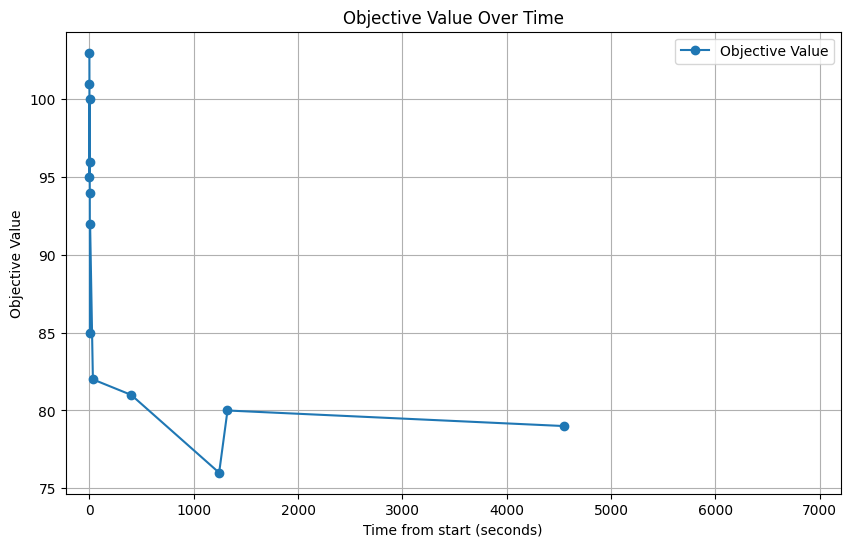

Statistics for `accepted` column:
{'True (Accepted)': np.int64(13), 'False (Rejected)': np.int64(28), 'Null (Not Validated/Error)': np.int64(0)}


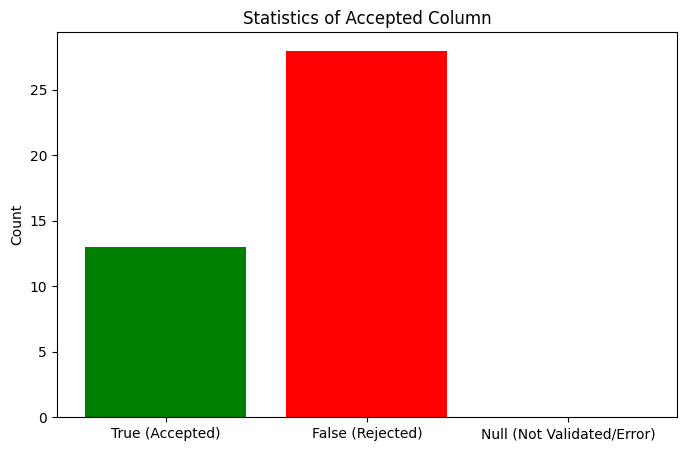

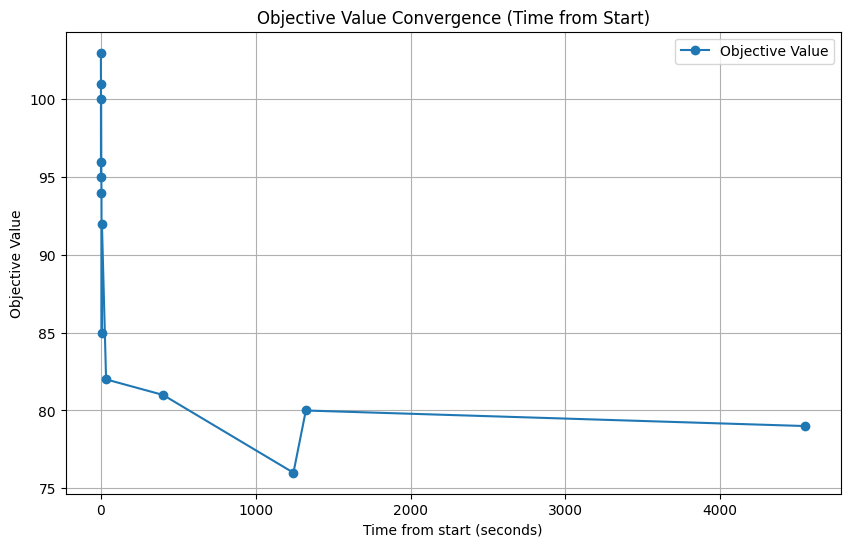

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import os

## Data

# Experiment
experiment = "results_final/glass-sc_randomheuristic/glass-sc_2hours_5agents_heuristic_2"

# Parameters
DATABASE_PATH = os.path.join(experiment, "central_node.db")  # Path to your SQLite database
BEST_KNOWN_SOLUTION = 288	  # Replace with the best-known solution's objective value

# Connect to the database
conn = sqlite3.connect(DATABASE_PATH)

# Fetch data
query = """
SELECT 
    id,
    submission_time, 
    validation_end_time, 
    objective_value, 
    accepted 
FROM all_solutions
"""
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Ensure datetime columns are parsed correctly
df['submission_time'] = pd.to_datetime(df['submission_time'])
df['validation_end_time'] = pd.to_datetime(df['validation_end_time'])

# Filter only valid solutions (accepted = TRUE)
valid_solutions = df[df['accepted'] == 1]
#valid_solutions = df

# Sort by submission time
valid_solutions = valid_solutions.sort_values(by="submission_time")
#valid_solutions = valid_solutions.iloc[:-3]


## Convergance plot of objective value for accepted solutions (time from beginning to end of experiment)

# New column for time from start
experiment_total_time = 7200 # 2 hours
valid_solutions['time_from_start'] = (valid_solutions['submission_time'] - valid_solutions['submission_time'].iloc[0]).dt.total_seconds()

# Plot the time series of objective values
plt.figure(figsize=(10, 6))
plt.plot(valid_solutions['time_from_start'], valid_solutions['objective_value'], label="Objective Value", marker='o')
plt.xlim(right=experiment_total_time)
plt.title("Objective Value Over Time")
plt.xlabel("Time from start (seconds)")
plt.ylabel("Objective Value")
plt.legend()
plt.grid()
plt.show()


## Bar plot for solution submission results (accepted/rejected/null)
accepted_stats = {
    'True (Accepted)': df['accepted'].sum() if df['accepted'].notna().sum() > 0 else 0,
    'False (Rejected)': (df['accepted'] == 0).sum(),
    'Null (Not Validated/Error)': df['accepted'].isna().sum(),
}

print("Statistics for `accepted` column:")
print(accepted_stats)

# Bar plot for statistics
labels = list(accepted_stats.keys())
values = list(accepted_stats.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['green', 'red', 'grey'])
plt.title("Statistics of Accepted Column")
plt.ylabel("Count")
plt.show()


## Convergance plot of objective value for accepted solutions (only time until last solution found)
valid_solutions['time_from_start'] = (valid_solutions['submission_time'] - valid_solutions['submission_time'].iloc[0]).dt.total_seconds()

plt.figure(figsize=(10, 6))
plt.plot(valid_solutions['time_from_start'], valid_solutions['objective_value'], label="Objective Value", marker='o')
plt.title("Objective Value Convergence (Time from Start)")
plt.xlabel("Time from start (seconds)")
plt.ylabel("Objective Value")
plt.legend()
plt.grid()
plt.show()

#### Final

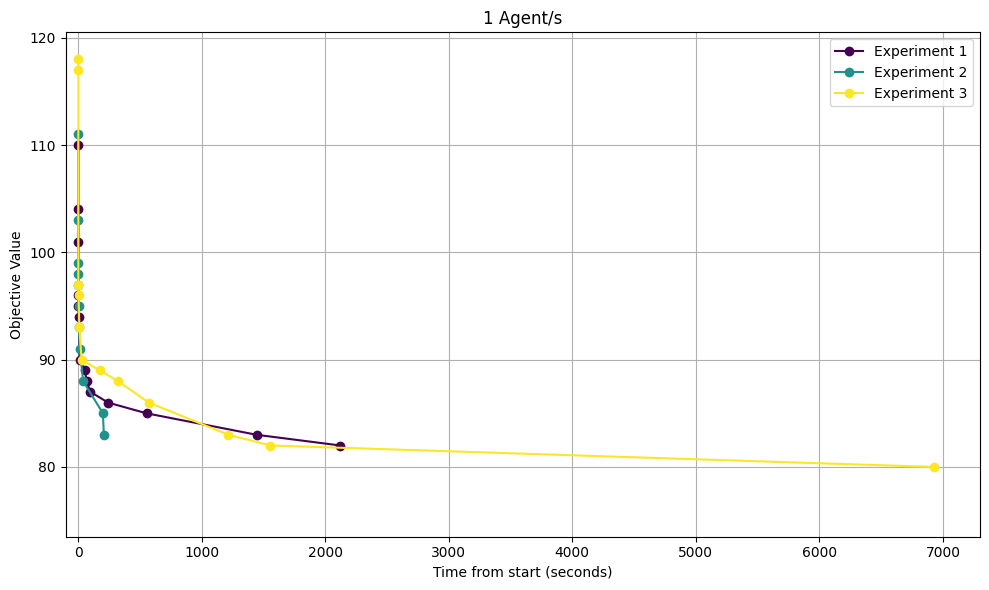

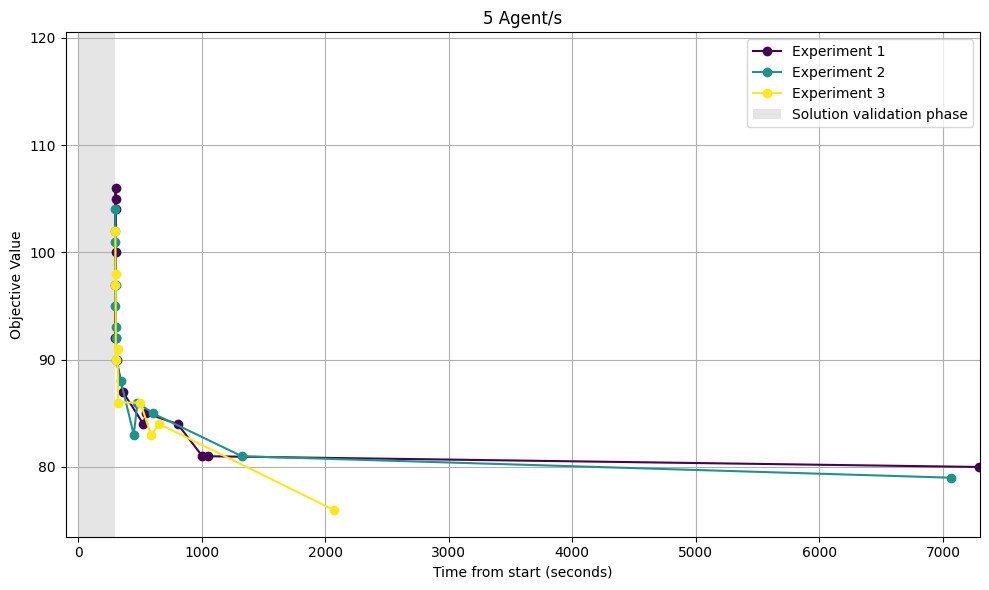

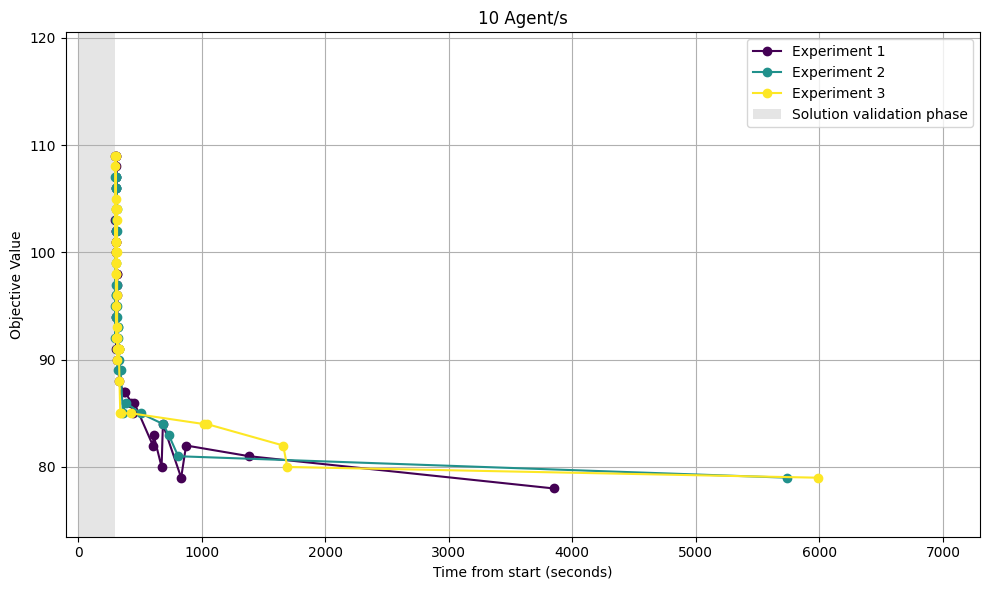

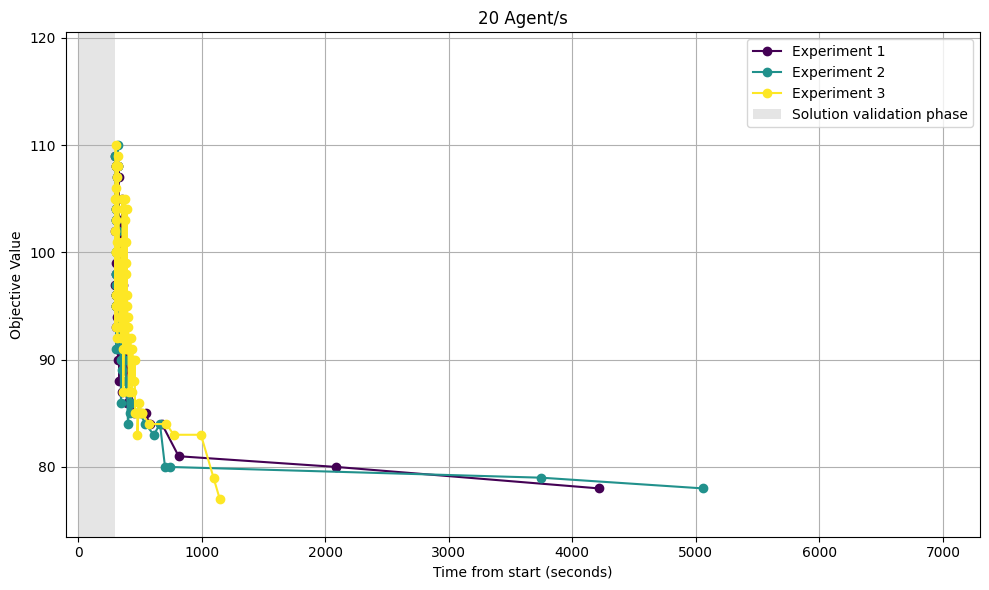

In [25]:
## Cleaner version of the convergance plot of objective value where we plot all experiments (for same number of agents) on the same plot ##

import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pathlib
from dotenv import load_dotenv


## Data

problem_instance = "glass-sc_randomguess"

# Define the path to the main experiments directory
experiments_dir = f'results_final/{problem_instance}'
BEST_KNOWN_SOLUTION = 288  # Replace with the best-known solution's objective value
experiment_total_time = 7200 # 2 hours
load_dotenv(dotenv_path=f'{experiments_dir}/network.params')
sol_val_phase_duration = int(os.getenv('SOLUTION_VALIDATION_DURATION'))  # Example duration in seconds (read one of the from network.params file)

# Function to read start timestamp from the log file
def get_start_time(log_file_path):
    with open(log_file_path, 'r') as file:
        lines = file.readlines()
        # Extract the timestamp from the third line
        start_time_str = lines[2].split(' - ')[0].strip()
        start_time = datetime.strptime(start_time_str, '%Y-%m-%d %H:%M:%S,%f')
        return start_time
    
# Function to process and plot convergence for a single experiment
def process_experiment(db_path, start_time, num_agents):
    # Connect to the database
    conn = sqlite3.connect(db_path)

    # Fetch data
    query = """
    SELECT 
        id,
        submission_time, 
        validation_end_time, 
        objective_value, 
        accepted 
    FROM all_solutions
    """
    df = pd.read_sql_query(query, conn)

    # Close the database connection
    conn.close()

    # Ensure datetime columns are parsed correctly
    df['submission_time'] = pd.to_datetime(df['submission_time'])
    df['validation_end_time'] = pd.to_datetime(df['validation_end_time'])

    # Filter only valid solutions (accepted = TRUE)
    valid_solutions = df[df['accepted'] == 1]

    # Sort by submission time
    valid_solutions = valid_solutions.sort_values(by="validation_end_time")

    # Calculate time from start - if only single agent then there is no solution validation phase so we use submission time
    if num_agents == 1:
        valid_solutions['time_from_start'] = (valid_solutions['submission_time'] - start_time).dt.total_seconds()
    else:
        valid_solutions['time_from_start'] = (valid_solutions['validation_end_time'] - start_time).dt.total_seconds()

    return valid_solutions

# Initialize a dictionary to store data for each type of experiment
convergence_data = {}

# Iterate through all experiment folders
for experiment_folder in os.listdir(experiments_dir):
    folder_path = os.path.join(experiments_dir, experiment_folder)
    if os.path.isdir(folder_path):
        db_file_path = os.path.join(folder_path, "central_node.db")  # Adjust the database file name if different
        log_file_path = list(pathlib.Path(folder_path).glob('*.log'))[0]  # Log file with the timestamp
        if os.path.exists(db_file_path) and os.path.exists(log_file_path):
            # Get start time from the log file
            start_time = get_start_time(log_file_path)

            # Determine the number of agents in this experiment based on the number of lines in solve_iterations.csv
            df = pd.read_csv(os.path.join(folder_path, "solve_iterations.csv"), header=None)
            num_agents = len(df)

            # Initialize the list for this agent count type if not already done
            if num_agents not in convergence_data:
                convergence_data[num_agents] = []

            # Process the experiment and store the result
            convergence_data[num_agents].append(process_experiment(db_file_path, start_time, num_agents))

# Sort by the number of agents
convergence_data = dict(sorted(convergence_data.items()))


## Plot all experiments on the same plot for each number of agents

# Find y-axis limits for all experiments
all_objective_values = [exp['objective_value'].values for experiments in convergence_data.values() for exp in experiments]
min_obj_value = min([min(obj_values) for obj_values in all_objective_values])
max_obj_value = max([max(obj_values) for obj_values in all_objective_values])

# Plot convergence for each type of experiment - show end time as well for better visualization of the time scale
for num_agents, experiments in convergence_data.items():
    plt.figure(figsize=(10, 6))

    colors = plt.cm.viridis(np.linspace(0, 1, len(experiments)))  # Use a colormap for consistent color
    
    for i, (experiment_data, color) in enumerate(zip(experiments, colors)):
        plt.plot(experiment_data['time_from_start'], experiment_data['objective_value'], 
                 label=f"Experiment {i+1}", marker='o', color=color)
        
    #plt.axhline(y=BEST_KNOWN_SOLUTION, color='r', linestyle='--', label="Best Known Solution")
    plt.xlim(-100, experiment_total_time+100)  # Set custom x-
    plt.ylim(min_obj_value - 2.5, max_obj_value + 2.5)  # Set custom y-axis limits


        
    # Annotate solution validation phase - if only single agent then there is no solution validation phase
    # Add a transparent horizontal box for the solution validation phase
    if num_agents != 1:
        # Calculate the absolute positions of the box
        min_start_time = min(exp['time_from_start'].iloc[0] for exp in experiments)
        left_hand_side = min_start_time - sol_val_phase_duration  # Left-hand side of the box
        right_hand_side = min_start_time  # Right-hand side of the box

        # Normalize these positions based on the current x-axis limits
        lower_xlim, upper_xlim = plt.xlim()
        normalized_xmin = (left_hand_side - lower_xlim) / (upper_xlim - lower_xlim)
        normalized_xmax = (right_hand_side - lower_xlim) / (upper_xlim - lower_xlim)

        # Add the horizontal span
        plt.axhspan(
            ymin=plt.ylim()[0], 
            ymax=plt.ylim()[1], 
            xmin=normalized_xmin, 
            xmax=normalized_xmax, 
            facecolor='gray', alpha=0.2, label="Solution validation phase"
        )
 
    
    plt.title(f"{num_agents} Agent/s")
    plt.xlabel("Time from start (seconds)")
    plt.ylabel("Objective Value")
    plt.legend()
    plt.grid()
    plt.tight_layout()  # Adjust the layout for better spacing
    #plt.savefig(f"img/convergence_plot_{problem_instance}_{num_agents}_agents.pdf")
    plt.show()


In [26]:
## Summary statistics for all experiments

import os
import sqlite3
import pandas as pd

problem_instance = "reblock354"

# Define the path to experiments directory
experiments_dir = f'results_final/{problem_instance}'
BEST_KNOWN_SOLUTION = -39280521.2281657  # Replace with the actual best-known solution

# Initialize a list to store results
results = []

# Loop through each experiment folder
for experiment_folder in os.listdir(experiments_dir):
    experiment_path = os.path.join(experiments_dir, experiment_folder)
    
    if os.path.isdir(experiment_path):
    
        # Path to the database
        database_path = os.path.join(experiment_path, "central_node.db")
        
        # Connect to the database
        conn = sqlite3.connect(database_path)
        
        # Fetch the number of agents from the agent_nodes table
        num_agents_query = "SELECT COUNT(*) AS num_agents FROM agent_nodes"
        num_agents = pd.read_sql_query(num_agents_query, conn)['num_agents'].iloc[0]
        
        # Fetch the best objective value
        best_objective_query = """
        SELECT 
            objective_value
        FROM all_solutions
        WHERE
            id = 
            (
                SELECT 
                    solution_id
                FROM best_solutions
            )
        """
        best_objective = pd.read_sql_query(best_objective_query, conn)['objective_value'].iloc[0]
        
        conn.close()
        
        # Append the result for this experiment
        results.append({
            "Number of Agents": num_agents,
            "Best Objective Value": best_objective
        })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Group by number of agents to calculate averages
summary_df = results_df.groupby("Number of Agents").agg({
    "Best Objective Value": "mean"
}).reset_index().rename(columns={
    "Best Objective Value": "Average Best Objective Value",
})

# Add the number of experiments for each type of experiment (1 agent, 5 agents, 10, etc.) - sanity check
summary_df['Number of Experiments'] = results_df.groupby("Number of Agents").size().reset_index(name='Number of Experiments')['Number of Experiments']

# Calculate the deviation from the best-known solution
summary_df["Deviation from Best Known Objective (%)"] = np.abs( (BEST_KNOWN_SOLUTION - summary_df["Average Best Objective Value"]) / BEST_KNOWN_SOLUTION ) * 100

# Display the summary DataFrame
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(summary_df)


   Number of Agents  Average Best Objective Value  Number of Experiments  \
0                 1                 -19648583.231                      3   
1                 5                 -20294770.595                      3   
2                10                 -20820066.789                      3   
3                20                 -20356357.246                      3   

   Deviation from Best Known Objective (%)  
0                                   49.979  
1                                   48.334  
2                                   46.996  
3                                   48.177  


## 20 random problem instances

In [27]:
import os
import sqlite3
import pandas as pd
import numpy as np

## Data

problem_instance = "cvs16r106-72"
print("Problem instance:", problem_instance)
problem_instance_path_20agents = f'results_final/20_random_problems_2hours_20agents_heuristic/{problem_instance}_20agents_heuristic'
problem_instance_path_1agent = f'results_final/20_random_problems_2hours_1agent_heuristic/{problem_instance}_1agent_heuristic'
BEST_KNOWN_SOLUTION = 19294.1
print("Best known solution:", BEST_KNOWN_SOLUTION)

# Path to the database
print("1 agent")
database_path = os.path.join(problem_instance_path_1agent, "central_node.db")

# Connect to the database
conn = sqlite3.connect(database_path)

# Best objective value
best_objective_query = """
        SELECT 
            objective_value
        FROM all_solutions
        WHERE
            id = 
            (
                SELECT 
                    solution_id
                FROM best_solutions
            )
        """
best_objective_df = pd.read_sql_query(best_objective_query, conn)
if best_objective_df.empty:
    print("Best objective value: Not found")
else:
    best_objective_value_1agent = best_objective_df['objective_value'].iloc[0]
    print("Best objective value:", best_objective_value_1agent)
    print("Deviation from best known solution:", np.abs( (BEST_KNOWN_SOLUTION - best_objective_value_1agent) / BEST_KNOWN_SOLUTION ) * 100, "%")

# All solutions
query = """
SELECT
    id,
    submission_time,
    objective_value,
    accepted
FROM all_solutions
"""
all_solutions_df = pd.read_sql_query(query, conn).sort_values(by="objective_value")
all_solutions_df.dropna(subset=['objective_value'], inplace=True)
all_solutions_df = all_solutions_df[all_solutions_df['accepted'] == 1]
if all_solutions_df.empty:
    print("No solutions found")
else:
    worst_objective_value = all_solutions_df['objective_value'].iloc[-1]
    print("Worst objective value:", worst_objective_value)
    #print("Improvement from worst to best:", np.abs( (worst_objective_value - best_objective_value_1agent) / worst_objective_value) * 100, "%")
    print("Improvement from worst to best:", ( np.abs(worst_objective_value - best_objective_value_1agent) / min(np.abs(worst_objective_value),np.abs(best_objective_value_1agent)) )* 100, "%")

# Close the connection
conn.close()

# Total solve iterations
solve_iterations_path = os.path.join(problem_instance_path_1agent, "solve_iterations.csv")
solve_iterations_df = pd.read_csv(solve_iterations_path, header=None)
total_solve_iterations = solve_iterations_df.iloc[:,1].sum()
print("Total solve iterations:", total_solve_iterations)

# Path to the database
print("20 agents")
database_path = os.path.join(problem_instance_path_20agents, "central_node.db")

# Connect to the database
conn = sqlite3.connect(database_path)

# Best objective value
best_objective_query = """
        SELECT 
            objective_value
        FROM all_solutions
        WHERE
            id = 
            (
                SELECT 
                    solution_id
                FROM best_solutions
            )
        """
best_objective_df = pd.read_sql_query(best_objective_query, conn)
if best_objective_df.empty:
    print("Best objective value: Not found")
else:
    best_objective_value_20agents = best_objective_df['objective_value'].iloc[0]
    print("Best objective value:", best_objective_value_20agents)
    print("Deviation from best known solution:", np.abs( (BEST_KNOWN_SOLUTION - best_objective_value_20agents) / BEST_KNOWN_SOLUTION ) * 100, "%")

# All solutions
query = """
SELECT
    id,
    submission_time,
    objective_value,
    accepted
FROM all_solutions
"""
all_solutions_df = pd.read_sql_query(query, conn).sort_values(by="objective_value")
all_solutions_df.dropna(subset=['objective_value'], inplace=True)
all_solutions_df = all_solutions_df[all_solutions_df['accepted'] == 1]
if all_solutions_df.empty:
    print("No solutions found")
else:
    worst_objective_value = all_solutions_df['objective_value'].iloc[-1]
    print("Worst objective value:", worst_objective_value)
    #print("Improvement from worst to best:", np.abs( (worst_objective_value - best_objective_value_20agents) / worst_objective_value) * 100, "%")
    print("Improvement from worst to best:", ( np.abs(worst_objective_value - best_objective_value_20agents) / min(np.abs(worst_objective_value),np.abs(best_objective_value_20agents)) )* 100, "%")


# Close the connection
conn.close()

# Total solve iterations
solve_iterations_path = os.path.join(problem_instance_path_20agents, "solve_iterations.csv")
solve_iterations_df = pd.read_csv(solve_iterations_path, header=None)
total_solve_iterations = solve_iterations_df.iloc[:,1].sum()
print("Total solve iterations:", total_solve_iterations)

# Differnce between 1 agent and 20 agents
if not best_objective_df.empty:
    if best_objective_value_20agents <= best_objective_value_1agent:
        #print("Improvement using 20 agents from 1 agent:", np.abs( (best_objective_value_20agents - best_objective_value_1agent) / best_objective_value_1agent )* 100, "%")
        print("Improvement using 20 agents from 1 agent:", ( np.abs(best_objective_value_20agents - best_objective_value_1agent) / min(np.abs(best_objective_value_20agents),np.abs(best_objective_value_1agent)) )* 100, "%")
    else:
        print("NO IMPROVEMENT using 20 agents from 1 agent")
        #print("Improvement using 1 agent from 20 agents:", np.abs( (best_objective_value_1agent - best_objective_value_20agents) / best_objective_value_20agents )* 100, "%")
        print("Improvement using 1 agent from 20 agents:", ( np.abs(best_objective_value_1agent - best_objective_value_20agents) / min(np.abs(best_objective_value_20agents),np.abs(best_objective_value_1agent)) )* 100, "%")

Problem instance: cvs16r106-72
Best known solution: 19294.1
1 agent
Best objective value: -30.0
Deviation from best known solution: 100.15548794709264 %
Worst objective value: -20.0
Improvement from worst to best: 50.0 %
Total solve iterations: 159314
20 agents
Best objective value: -32.0
Deviation from best known solution: 100.16585381023215 %
Worst objective value: -21.0
Improvement from worst to best: 52.38095238095239 %
Total solve iterations: 3104247
Improvement using 20 agents from 1 agent: 6.666666666666667 %


## Speedup plots of solution iterations

   #agents  sol_iterations  speedup
1        1      594210.333    1.000
3        5     3031392.000    5.102
0       10     5998908.333   10.096
2       20    11733230.333   19.746


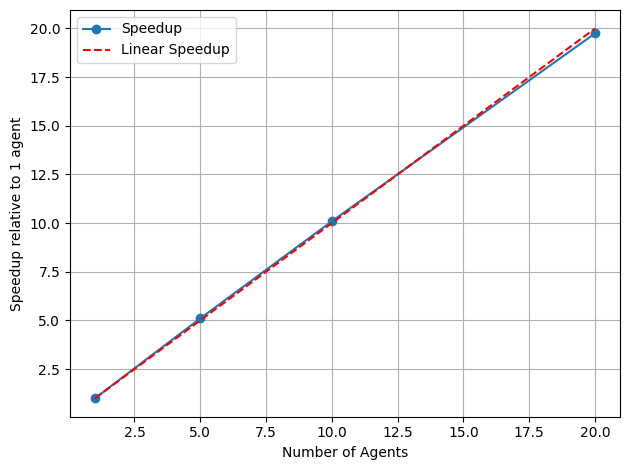

In [ ]:
## See how the scalability of the solution iterations is with increasing number of agents

# NOTE: The iterations were not calculated correctly for all experiments, so the results might not be accurate for some instances
# (should be OK for rebloack354 and glass-sc)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the problem instance
problem_instance = "glass-sc_randomguess"

# Define the path to the main experiments directory
experiments_dir = f'results_final/{problem_instance}'

# Initialize a dictionary to store data for each agent count
results = {}

# Iterate through all experiment folders
for experiment_folder in os.listdir(experiments_dir):
    folder_path = os.path.join(experiments_dir, experiment_folder)
    if os.path.isdir(folder_path):
        csv_file_path = os.path.join(folder_path, 'solve_iterations.csv')
        if os.path.exists(csv_file_path):
            # Read the CSV file
            df = pd.read_csv(csv_file_path, header=None)
            num_agents = len(df)

            # Compute the sum for this single experiment
            avg_iterations = df[1].sum()

            # Accumulate data for each number of agents
            if num_agents not in results:
                results[num_agents] = []
            results[num_agents].append(avg_iterations)

# Prepare final results for plotting
final_results = []
for num_agents, iterations_list in results.items():
    avg_iterations_over_experiments = np.mean(iterations_list)
    final_results.append({'#agents': num_agents, 'sol_iterations': avg_iterations_over_experiments})

# Convert to DataFrame
final_df = pd.DataFrame(final_results).sort_values(by='#agents')

# Speed up relative to 1 agent
single_agent_iterations = final_df.loc[final_df['#agents'] == 1, 'sol_iterations'].values[0]
final_df['speedup'] = final_df['sol_iterations'] / single_agent_iterations

# Print the final DataFrame
print(final_df)

# Plotting
plt.plot(final_df['#agents'], final_df['speedup'], marker='o', label='Speedup')
agents_range = np.linspace(final_df['#agents'].min(), final_df['#agents'].max(), 100)
plt.plot(agents_range, agents_range, linestyle='--', color='red', label='Linear Speedup')
plt.xlabel('Number of Agents')
plt.ylabel('Speedup relative to 1 agent')
#plt.title(f'Scalability of Solution Iterations with Increasing \n Number of Agents ({problem_instance})')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig(f'img/{problem_instance}_scalability.png')
plt.show()

## Rewards (Extra stuff)

Total rewards for all agents on average:
4712.333333333333


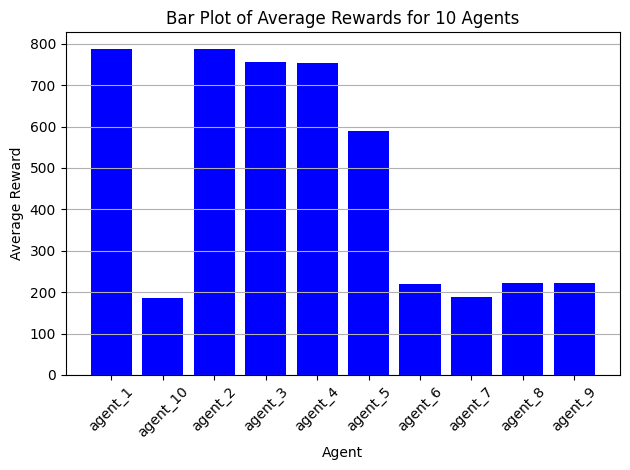

Total rewards for all agents on average:
1233.3333333333333


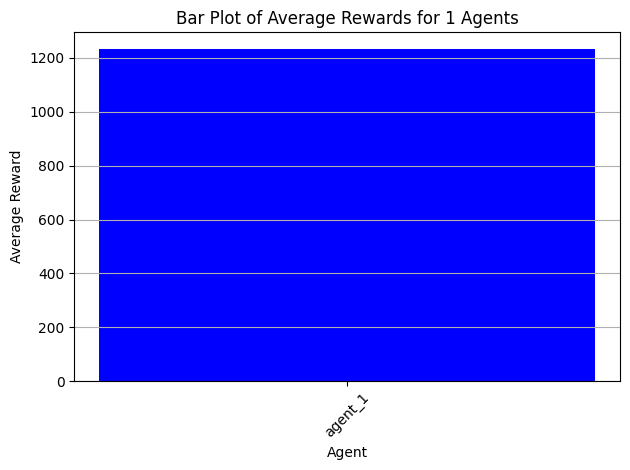

Total rewards for all agents on average:
10249.0


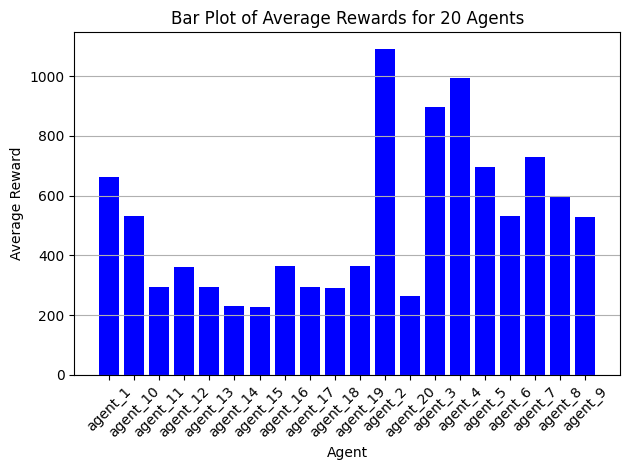

Total rewards for all agents on average:
1454.6666666666667


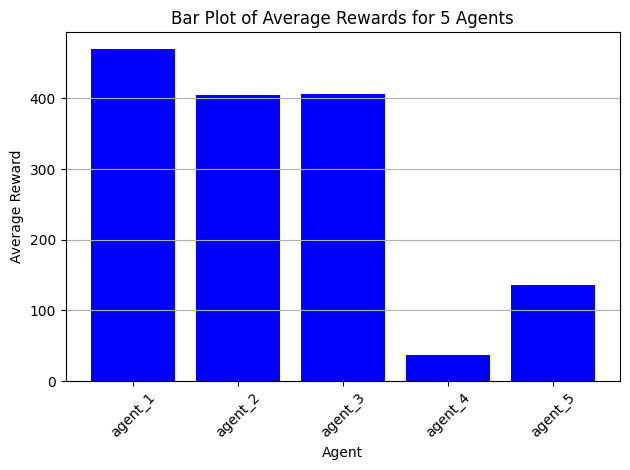

In [ ]:
## Plot the average reward for each agent for the experiments

# NOTE: this is not a focus point, we just wanted to see how the rewards are distributed for different agents
# (should be uniform more or less)

import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the problem instance
problem_instance = "glass-sc_randomguess"

# Define the path to the main experiments directory
experiments_dir = f'results_final/{problem_instance}'

# Initialize a dictionary to store rewards for each agent count type
rewards_data = {}

# Iterate through all experiment folders
for experiment_folder in os.listdir(experiments_dir):
    folder_path = os.path.join(experiments_dir, experiment_folder)
    if os.path.isdir(folder_path):
        csv_file_path = os.path.join(folder_path, 'rewards.csv')  # Adjust the file name if different
        if os.path.exists(csv_file_path):
            # Read the CSV file
            df = pd.read_csv(csv_file_path, header=None)
            df.columns = ['agent', 'case', 'reward']
            
            # Determine the number of agents in this experiment (unique agents)
            num_agents = len(df['agent'].unique())

            # Initialize the list for this agent count type if not already done
            if num_agents not in rewards_data:
                rewards_data[num_agents] = {}

            # Group by agent and compute the average reward
            avg_rewards = df.groupby('agent')['reward'].mean()
            for agent, avg_reward in avg_rewards.items():
                if agent not in rewards_data[num_agents]:
                    rewards_data[num_agents][agent] = []
                rewards_data[num_agents][agent].append(avg_reward)

# Compute overall average for each agent and plot
for num_agents, agents_rewards in rewards_data.items():
    avg_rewards_per_agent = {agent: sum(rewards)/len(rewards) for agent, rewards in agents_rewards.items()}
    #total_rewards = sum(avg_rewards_per_agent.values())

    sum(avg_rewards_per_agent.values())

    print("Total rewards for all agents on average:")
    print(sum(avg_rewards_per_agent.values()))
    
    plt.figure()
    plt.bar(avg_rewards_per_agent.keys(), avg_rewards_per_agent.values(), color='blue')
    plt.xlabel('Agent')
    plt.ylabel('Average Reward')
    plt.title(f'Bar Plot of Average Rewards for {num_agents} Agents')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
